### set session

In [75]:
name = 'ANM1'
session = '20240203_d5'
num_trials = 64
threshold_shift = 0.0

### imports

In [76]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from jerk.get_jerks import get_jerks
from jerk.calculate_minimum_jerk import solve_x_coefficients, minimum_jerk_function, smoothest_x_function, get_index_a_b, get_boundary_conditions

In [77]:
PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

set_matplotlib_settings()

for mac:

In [78]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM1/Jerk_ANM1_20240203_d5/: File exists


for windows:

In [79]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM1/Jerk_ANM1_20240203_d5/: File exists


### calculate jerks for all trials

In [80]:
get_jerks(num_trials, PreprocessLeverData_folder, output_folder)

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$


In [81]:
jerk_ratios = []
movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
for movement_information in movement_informations:
    
    trial_index = int(movement_information[0])
    left_index, right_index = movement_information[1:]
    left_index = int(left_index)
    right_index = int(right_index)
    index_a, index_b = get_index_a_b(trial_index, left_index, right_index, PreprocessLeverData_folder)
    index_c = right_index

    # rising lever press:
    x_0, v_0, a_0, x_f, v_f, a_f, tf = get_boundary_conditions(index_a, index_b, trial_index, PreprocessLeverData_folder, output_folder)

    smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
    t_input = np.linspace(0, tf, index_b - index_a)
    smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)

    jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
    abs_jerk = np.abs(jerk)
    sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
    actual_jerk_dx = np.median(np.diff(sample_times))
    actual_cumulative_jerk_ab = np.trapz(abs_jerk[index_a:index_b], dx=actual_jerk_dx)

    minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
    minimum_jerk = np.array(minimum_jerk, dtype=float)
    abs_minimum_jerk = np.abs(minimum_jerk)
    minimum_jerk_dx = np.median(np.diff(t_input))
    minimum_cumulative_jerk_ab = np.trapz(abs_minimum_jerk, dx=minimum_jerk_dx)

    # falling lever press:
    x_0, v_0, a_0, x_f, v_f, a_f, tf = get_boundary_conditions(index_b, index_c, trial_index, PreprocessLeverData_folder, output_folder)

    smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
    t_input = np.linspace(0, tf, index_c - index_b)
    smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)

    jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
    abs_jerk = np.abs(jerk)
    sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
    actual_jerk_dx = np.median(np.diff(sample_times))
    actual_cumulative_jerk_bc = np.trapz(abs_jerk[index_b:index_c], dx=actual_jerk_dx)

    minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
    minimum_jerk = np.array(minimum_jerk, dtype=float)
    abs_minimum_jerk = np.abs(minimum_jerk)
    minimum_jerk_dx = np.median(np.diff(t_input))
    minimum_cumulative_jerk_bc = np.trapz(abs_minimum_jerk, dx=minimum_jerk_dx)

    # append jerk ratio:
    jerk_ratio = (actual_cumulative_jerk_ab+actual_cumulative_jerk_bc) / (minimum_cumulative_jerk_ab+minimum_cumulative_jerk_bc)
    if jerk_ratio < 1: # 0.8 and 0.9's probably due to damping, just round up
        print("Warning jerk ratio was < 1, will be rounded up to 1:", jerk_ratio)
        jerk_ratio = 1
    jerk_ratios.append([trial_index, jerk_ratio, (actual_cumulative_jerk_ab+actual_cumulative_jerk_bc), (minimum_cumulative_jerk_ab+minimum_cumulative_jerk_bc)])

jerk_ratios = np.array(jerk_ratios)
np.save(output_folder+"jerk_ratios", jerk_ratios)

Plot the histogram

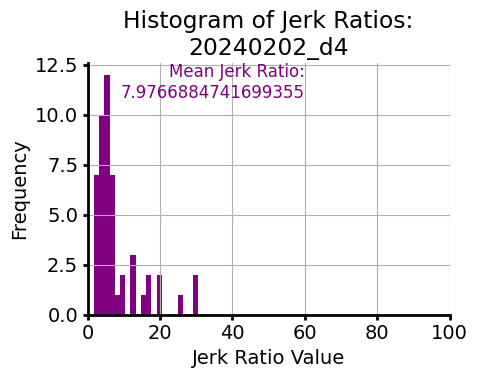

In [ ]:
plt.hist(jerk_ratios[:, 1], bins=20, color='purple')
plt.title('Histogram of Jerk Ratios:\n'+session)
plt.xlabel('Jerk Ratio Value')
plt.ylabel('Frequency')
plt.xlim([0, 100])
plt.grid(True)
plt.text(60, max(plt.ylim()), "Mean Jerk Ratio:\n"+ str(np.mean(jerk_ratios[:, 1])), ha='right', va='top', fontsize=12, color='purple')

plt.savefig(output_folder+"plot_jerk_ratios.png")
plt.show()

### Plot single jerk if needed

smoothest x sampling frequency:  5866.480242708452
Minimum Cumulative Jerk: 1348.6928896628328
Actual Cumulative Jerk^2: 2470.6160188410754
jerk ratio actual/minimum: 1.8318596010828814


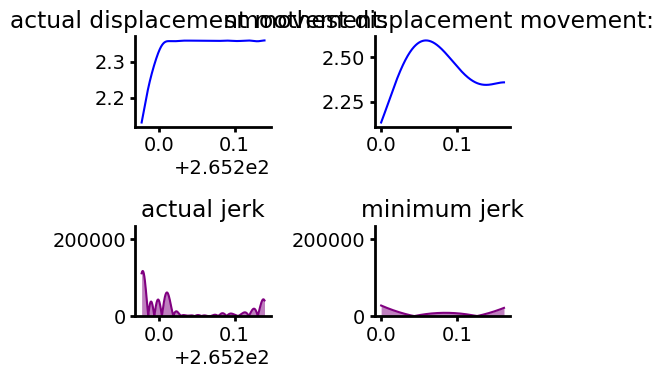

In [ ]:
movement_information = movement_informations[1]
trial_index = int(movement_information[0])

left_index, right_index = movement_information[1:]
left_index = int(left_index)
right_index = int(right_index)
index_a, index_b = get_index_a_b(trial_index, left_index, right_index, PreprocessLeverData_folder)
x_0, v_0, a_0, x_f, v_f, a_f, tf = get_boundary_conditions(index_a, index_b, trial_index, PreprocessLeverData_folder, output_folder)

smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
t_input = np.linspace(0, tf, index_b - index_a)
print("smoothest x sampling frequency: ", 1/ (np.median(np.diff(t_input))))
smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)

jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
abs_jerk = np.abs(jerk)
leverdata = np.fromfile(PreprocessLeverData_folder+"processed_trial"+str(trial_index)+".bin", dtype=np.double)
sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
actual_jerk_dx = np.median(np.diff(sample_times))
actual_cumulative_jerk = np.trapz(abs_jerk[index_a:index_b], dx=actual_jerk_dx)

minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
minimum_jerk = np.array(minimum_jerk, dtype=float)
abs_minimum_jerk = np.abs(minimum_jerk)
minimum_jerk_dx = np.median(np.diff(t_input))
minimum_cumulative_jerk = np.trapz(abs_minimum_jerk, dx=minimum_jerk_dx)

jerk_ratio = actual_cumulative_jerk / minimum_cumulative_jerk

print("Minimum Cumulative Jerk:", str(minimum_cumulative_jerk))
print("Actual Cumulative Jerk^2:",str(actual_cumulative_jerk))
print("jerk ratio actual/minimum:", jerk_ratio)

plt.subplot(2,2,1)
plt.plot(sample_times[index_a:index_b], leverdata[index_a:index_b], color='blue')
plt.title("actual displacement movement: ")

plt.subplot(2,2,2)
plt.plot(t_input, smoothest_x, color='blue')
plt.title("smoothest displacement movement: ")

plt.subplot(2, 2, 3)
plt.plot(sample_times[index_a:index_b], abs_jerk[index_a:index_b], color='purple')
plt.fill_between(sample_times[index_a:index_b], 0, abs_jerk[index_a:index_b], color='purple', alpha=0.5, linewidth=0.0)
plt.ylim([0, max(abs_jerk[index_a:index_b])*2])
plt.title("actual jerk")

plt.subplot(2, 2, 4)
plt.plot(t_input, abs_minimum_jerk, color='purple')
plt.fill_between(t_input, 0, abs_minimum_jerk, color='purple', alpha=0.5, zorder=2, linewidth=0.0)
plt.ylim([0, max(abs_jerk[index_a:index_b])*2])
plt.title("minimum jerk")

plt.show()